# Naive Bayes Classifier: SMS - spam/ham

1. Use sklearn.naive_bayes modules as the classifier to determine if a text message is SPAM or not (HAM).
2. We will compare different approaches to feature selection CountVectorizer / tf-idf $c=\sqrt{a^2}$
3. We will compare different flavors of Naive Bayes: Gaussian, Multinomial, Bernoulli.

$$c = \sqrt{a^2 + b^2}$$

## Import Modules
Let's get the usual suspects for data science.
Also we will use matplotlib and seaborn for plotting

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
import csv
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, learning_curve 
from sklearn.tree import DecisionTreeClassifier 

## Import SMS data
Use rstrip() to remove any additional whitespace after each message

In [3]:
messages = [ line.rstrip() for line in open('SMSSpamCollection')]

Take a look at the first few messages

In [4]:
for number,entry in enumerate(messages[:10]):
    print number, entry

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

Now we'll create a dataframe to help digest the data. The columns are tab-separated. Instruct pandas not to use quotes when reading in fields: csv.QUOTE_NONE.

In [5]:
data = pd.read_csv('SMSSpamCollection.txt',sep='\t',names=["label","message"],quoting=csv.QUOTE_NONE)

Let's get some info about our data set.

In [6]:
data.describe()

,label,message
count,5574,5574
unique,2,5171
top,ham,"Sorry, I'll call later"
freq,4827,30


So we have a corpus of 5574 messages, of which 5171 are unique. Most of them (4827) are actually messages (HAM), of which 'Sorry, I'll call later' is the most frequent. 

In [7]:
data.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's introduce another field into the data frame: 'length.' Which is the number of words in the message

In [8]:
data['length']=data['message'].map(lambda msg: len(msg))
data.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Now let's look at the distribution of lengths for each label

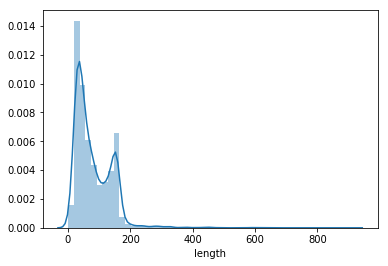

In [9]:
sns.distplot(data['length'])

Now see some statistics on the lengths of messages

In [10]:
data['length'].describe()

count    5574.000000
mean       80.604593
std        59.919970
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

What is the very long message?

In [11]:
print list(data.message[data.length>900])

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


View the length distributions by label

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a0d1eca10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a0cd53250>], dtype=object)

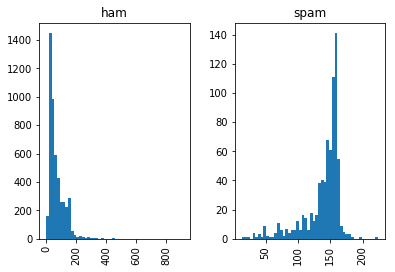

In [12]:
data.hist(column='length', by='label', bins=50)

With seaborn this can be done using facet grid

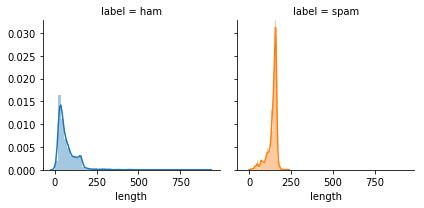

In [13]:
facet = sns.FacetGrid(data,hue='label',col='label')
facet.map(sns.distplot,'length')

## Preprocessing
Now we need to take out symbols and punctuation to get a better representation of the message

First, we convert everything to unicode, then use the TextBlob module to extract words...

In [14]:
def split_into_tokens(message):
    message=unicode(message,'utf8')
    return TextBlob(message).words

In [15]:
data.message.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [16]:
data.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

In [17]:
TextBlob('Learning Naive Bayes is Fun!')

TextBlob("Learning Naive Bayes is Fun!")

Now reduce words to their base form 'lemmas'

In [18]:
def split_into_lemmas(message):
    message=unicode(message,'utf8').lower()
    words = TextBlob(message).words
    return [word.lemma for word in words]

In [19]:
data.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

In [20]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(data['message'])


In [21]:
print len(bow_transformer.vocabulary_)
print bow_transformer.get_stop_words()

8859
None


In [22]:
test_msg = data['message'][4]
print test_msg

Nah I don't think he goes to usf, he lives around here though


In [23]:
test_bow = bow_transformer.transform([test_msg])
print test_bow
print test_bow.shape

  (0, 1320)	1
  (0, 2770)	1
  (0, 3628)	1
  (0, 3858)	2
  (0, 3915)	1
  (0, 4098)	1
  (0, 4708)	1
  (0, 5316)	1
  (0, 5328)	1
  (0, 7709)	1
  (0, 7728)	1
  (0, 7801)	1
  (0, 8139)	1
(1, 8859)


which entry has 2 words?

In [24]:
print bow_transformer.get_feature_names()[3858]

he


In [25]:
data_bow = bow_transformer.transform(data['message'])

In [26]:
print 'now we have a sparse matrix of shape', data_bow.shape
print 'with {} number of nonzer entries'.format(data_bow.nnz)
print 'Sparsity: {:.2f}%'.format(100. * data_bow.nnz \
                                 / (data_bow.shape[0] * data_bow.shape[1]))

now we have a sparse matrix of shape (5574, 8859)
with 80338 number of nonzer entries
Sparsity: 0.16%


In [27]:
% time spam_detector_MNB = MultinomialNB().fit(data_bow,data['label'])

CPU times: user 23.6 ms, sys: 2.05 ms, total: 25.6 ms
Wall time: 29.6 ms


In [28]:
% time spam_detector_GNB = GaussianNB().fit(data_bow.toarray(),data['label'])

CPU times: user 1.36 s, sys: 1.02 s, total: 2.37 s
Wall time: 3.91 s


In [29]:
% time spam_detector_BNB = BernoulliNB().fit(data_bow,data['label'])

CPU times: user 26 ms, sys: 4.93 ms, total: 30.9 ms
Wall time: 32.2 ms


In [32]:
print spam_detector_MNB.predict(test_bow)
print test_msg

['ham']
Nah I don't think he goes to usf, he lives around here though


In [34]:
print spam_detector_MNB.predict_proba(test_bow)

[[  1.00000000e+00   1.99090554e-13]]


In [35]:
print test_bow

  (0, 1320)	1
  (0, 2770)	1
  (0, 3628)	1
  (0, 3858)	2
  (0, 3915)	1
  (0, 4098)	1
  (0, 4708)	1
  (0, 5316)	1
  (0, 5328)	1
  (0, 7709)	1
  (0, 7728)	1
  (0, 7801)	1
  (0, 8139)	1


ok let's test predictive power between MNB,GNB,BBB (multinomial,gaussian,bernollui)
We want to set up a cross validation pipeline using Bernoulli and Multinmoial Classifiers.
First we need a training set and test set...

Use 80% of the data to train, 20% to test using train_test_split()

In [37]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(data['message'],data['label'],test_size=0.2)
print len(msg_train), len(msg_test)

4459 1115


Create a Pipeline which allows multiple steps to be performed on the input data

1. Vectorize the words
2. Weight using the TF-IDF scheme
3. Specify the classifier

In [38]:
pipeline=Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)), #strings to lemmas
    ('tfidf', TfidfTransformer()), #weighted TF-IDF
    ('classifier', MultinomialNB()) # Naive Bayes Classifier
])

Further subdivide the training data using Stratified Cross Validation, to make sure that our model is stable to different training sets. 

In [39]:
scores = cross_val_score(pipeline, # convert raw messages to a model
                        msg_train, # training data
                        label_train, # training labels
                        cv = 10, # split into 10 groups: 9 for training, 1 for testing
                        scoring = 'accuracy', # scoring metric
                        n_jobs = -1
                        )
print scores

[ 0.93064877  0.95973154  0.95964126  0.9573991   0.96188341  0.95067265
  0.9573991   0.94157303  0.94382022  0.95280899]


All scores are above 90% indicating decent accuracy and a stable model

In [40]:
print scores.mean(), scores.std()

0.951557807609 0.00951900372923


Now let's see if we can find the best combination of parameters for a model.
i.e.
1. how much feature engineering to do: lemmas or tokens?
2. what weighting scheme: just tf or iff as well?
3. BernoulliNB or MultinomialNB

In [49]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier',MultinomialNB())
])
params = {
    'tfidf__use_idf': (True,False),
    'bow__analyzer' : (split_into_lemmas,split_into_tokens),
}
grid = GridSearchCV(
    pipeline,
    params,
    refit = True,
    n_jobs = -1,
    scoring = 'accuracy',
    cv = 10
)

In [50]:
%time MNB_detector = grid.fit(msg_train, label_train)

CPU times: user 6.82 s, sys: 562 ms, total: 7.38 s
Wall time: 2min 53s
[mean: 0.95156, std: 0.00952, params: {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_lemmas at 0x1a0d1ed668>}, mean: 0.93564, std: 0.00992, params: {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_lemmas at 0x1a0d1ed668>}, mean: 0.95133, std: 0.00857, params: {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_tokens at 0x1a0cc15ed8>}, mean: 0.93519, std: 0.00952, params: {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_tokens at 0x1a0cc15ed8>}]


/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [59]:
print MNB_detector.cv_results_['mean_test_score']
print MNB_detector.cv_results_['params']

[ 0.95155865  0.93563579  0.95133438  0.93518726]
[{'tfidf__use_idf': True, 'bow__analyzer': <function split_into_lemmas at 0x1a0d1ed668>}, {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_lemmas at 0x1a0d1ed668>}, {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_tokens at 0x1a0cc15ed8>}, {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_tokens at 0x1a0cc15ed8>}]


In [52]:
pipeline_BNB = Pipeline([
    ('bow' , CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier',BernoulliNB())
])
params = {
    'tfidf__use_idf' : (True, False),
    'bow__analyzer' : (split_into_lemmas,split_into_tokens)
}
grid_BNB = GridSearchCV(
    pipeline,
    params,
    refit = True,
    n_jobs = -1,
    scoring = 'accuracy',
    cv = 10
)

In [53]:
%time BNB_detector = grid_BNB.fit(msg_train,label_train)

CPU times: user 6.8 s, sys: 317 ms, total: 7.11 s
Wall time: 2min 51s


In [58]:
print BNB_detector.cv_results_['mean_test_score']
print BNB_detector.cv_results_['params']


[ 0.95155865  0.93563579  0.95133438  0.93518726]
[{'tfidf__use_idf': True, 'bow__analyzer': <function split_into_lemmas at 0x1a0d1ed668>}, {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_lemmas at 0x1a0d1ed668>}, {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_tokens at 0x1a0cc15ed8>}, {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_tokens at 0x1a0cc15ed8>}]


In [62]:
print MNB_detector.predict(['hi mom how are you ?'])
print MNB_detector.predict_proba(['hi mom how are you ?'])

['ham']
[[ 0.99389696  0.00610304]]


In [65]:
print MNB_detector.predict(['WINNER! Credit for free!'])
print MNB_detector.predict_proba(['WINNER! Credit for free!'])

['spam']
[[ 0.36515646  0.63484354]]


In [66]:
predictions = MNB_detector.predict(msg_test)
print confusion_matrix(label_test, predictions)
print classification_report(label_test, predictions)

[[960   0]
 [ 66  89]]
             precision    recall  f1-score   support

        ham       0.94      1.00      0.97       960
       spam       1.00      0.57      0.73       155

avg / total       0.94      0.94      0.93      1115



In [69]:
pipeline_SVM = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC())
])

param_svm = [
    {'classifier__C' : [1,10,100,1000], 'classifier__kernel' : ['linear']},
    {'classifier__C' : [1,10,100,1000], 'classifier__gamma': [0.001,0.0001], 'classifier__kernel': ['rbf']}
]
grid_SVM = GridSearchCV(
    pipeline_SVM,
    param_svm,
    refit = True,
    n_jobs = -1,
    scoring = 'accuracy',
    cv = 10
)

In [70]:
%time SVM_detector = grid_SVM.fit(msg_train,label_train)

CPU times: user 9.95 s, sys: 983 ms, total: 10.9 s
Wall time: 11min 1s


In [73]:
print SVM_detector.cv_results_['mean_test_score']
print SVM_detector.cv_results_['params']

[ 0.98587127  0.9869926   0.9869926   0.9869926   0.86723481  0.86723481
  0.86723481  0.86723481  0.97308814  0.86723481  0.9876654   0.97308814]
[{'classifier__kernel': 'linear', 'classifier__C': 1}, {'classifier__kernel': 'linear', 'classifier__C': 10}, {'classifier__kernel': 'linear', 'classifier__C': 100}, {'classifier__kernel': 'linear', 'classifier__C': 1000}, {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 100}, {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 100}, {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 1000}, {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'class

In [74]:
predictions = SVM_detector.predict(msg_test)
print confusion_matrix(label_test,predictions)
print classification_report(label_test,predictions)

[[959   1]
 [ 12 143]]
             precision    recall  f1-score   support

        ham       0.99      1.00      0.99       960
       spam       0.99      0.92      0.96       155

avg / total       0.99      0.99      0.99      1115



In [76]:
print SVM_detector.predict(['hi mom how are you ?'])
print SVM_detector.predict(['WINNER! Credit for free!'])

['ham']
['spam']


In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True,annot=True,cmap='RdBu_r')
plt.title('Correlation matrix')
plt.show()

In [ ]:
scores = cross_val_score(pipeline, # specifies classifier
                        data_train, # training data
                        label_train, # training labels
                        cv = 10, # split into 10 groups: 9 for training, 1 for testing
                        scoring = 'accuracy', # scoring metric
                        n_jobs = -1
                        )
print(scores)

In [ ]:
% time wine_detector = grid.fit(data_train,label_train)

In [ ]:
% time wine_detector = GaussianNB().fit(data_train,label_train)

In [ ]:
predictions = wine_detector.predict(data_test)
print('accuracy', accuracy_score(label_test, predictions))
print('confusion matrix\n', 
      confusion_matrix(label_test, predictions))
print('(row=expected, col=predicted)')

In [ ]:
print(svm_detector.best_estimator_)